# Metodología: Híbrido de Reglas de Negocio y Autoencoder Variacional (VAE)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from xgboost import XGBClassifier

# --- Configuración Visual ---
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("colorblind")

## Parte 1: Implementación del Script Basado en Reglas (Manual)

In [8]:
# --- Carga y Preparación de Datos ---
print("Cargando el dataset de Zacatecas...")
df = pd.read_parquet('./datasets/declaraciones_procesadas_zacatecas.parquet', engine='fastparquet')
print(f"Dataset cargado con {df.shape[0]} filas y {df.shape[1]} columnas.")

# Convertir la columna de fecha para poder ordenarla
df['fecha_actualizacion'] = pd.to_datetime(df['fecha_actualizacion'])

# ============================================================
# PARTE 1: SCRIPT DE ETIQUETADO BASADO EN REGLAS DE NEGOCIO
# ============================================================

print("\nIniciando etiquetado de anomalías según el manual de verificación...")

# --- Regla 1: Ingreso Anual Neto Excesivo ---
umbral_ingreso = 2_000_000
df['anomalia_ingreso'] = df['ingreso_anual_neto_total'] > umbral_ingreso

# --- Regla 2: Discrepancia Activos vs. Ingresos ---
# Se considera anomalía si los activos son más de 5 veces el ingreso,
# y el ingreso no es cero para evitar divisiones infinitas.
multiplo_activos = 5
df['anomalia_discrepancia_activos'] = (
    (df['valor_total_activos'] > (df['ingreso_anual_neto_total'] * multiplo_activos)) &
    (df['ingreso_anual_neto_total'] > 0)
)

# --- Regla 3: Aumento Súbito de Activos (Análisis Histórico) ---
df = df.sort_values(by=['nombre_completo', 'fecha_actualizacion'])
# Calculamos la diferencia de activos con respecto a la declaración anterior del mismo funcionario
df['activos_previos'] = df.groupby('nombre_completo')['valor_total_activos'].shift(1)
df['aumento_activos'] = df['valor_total_activos'] - df['activos_previos']

# Umbral de aumento súbito (ej. un aumento de más de $1,000,000 en un año)
umbral_aumento = 1_000_000
df['anomalia_aumento_subito'] = (df['aumento_activos'] > umbral_aumento) & (df['activos_previos'].notna())

# --- Etiqueta Final: 'posible_anomalia' ---
# Una declaración se marca como anómala si cumple CUALQUIERA de las reglas.
df['posible_anomalia'] = (
    df['anomalia_ingreso'] |
    df['anomalia_discrepancia_activos'] |
    df['anomalia_aumento_subito']
).astype(int)

# --- Reporte del Etiquetado ---
total_anomalias = df['posible_anomalia'].sum()
porcentaje = (total_anomalias / len(df)) * 100

print(f"\nEtiquetado completado.")
print(f"Total de declaraciones marcadas como 'posible anomalía': {total_anomalias} ({porcentaje:.2f}%)")
print("\nDesglose de anomalías encontradas por regla:")
print(f"- Por Ingreso Excesivo: {df['anomalia_ingreso'].sum()}")
print(f"- Por Discrepancia Activos vs Ingreso: {df['anomalia_discrepancia_activos'].sum()}")
print(f"- Por Aumento Súbito de Activos: {df['anomalia_aumento_subito'].sum()}")

# Limpiamos columnas auxiliares
df = df.drop(columns=['anomalia_ingreso', 'anomalia_discrepancia_activos', 'anomalia_aumento_subito', 'activos_previos', 'aumento_activos'])

Cargando el dataset de Zacatecas...
Dataset cargado con 157683 filas y 18 columnas.

Iniciando etiquetado de anomalías según el manual de verificación...

Etiquetado completado.
Total de declaraciones marcadas como 'posible anomalía': 3446 (2.19%)

Desglose de anomalías encontradas por regla:
- Por Ingreso Excesivo: 2320
- Por Discrepancia Activos vs Ingreso: 844
- Por Aumento Súbito de Activos: 389


## Parte 2: Implementación de la Metodología Híbrida (VAE + XGBoost)


Iniciando implementación del modelo híbrido (VAE + XGBoost)...
Datos separados: 154237 declaraciones normales y 3446 anómalas.
Set de entrenamiento (VAE, solo normales): (107965, 8)
Set de validación (mixto): (24859, 8)
Set de prueba (mixto): (24859, 8)


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │        144 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         34 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         34 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 212 (848.00 B)

 Trainable params: 212 (848.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184 (736.00 B)

 Trainable params: 184 (736.00 B)

 Non-trainable params: 0 (0.00 B)


Entrenando el VAE (esto puede tardar unos minutos)...
Epoch 1/50
3374/3374 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - kl_loss: 67293.2656 - loss: -227981.9844 - reconstruction_loss: -295275.1875 - val_kl_loss: 44220332.0000 - val_loss: -378612000.0000 - val_reconstruction_loss: -422832320.0000
Epoch 2/50
3374/3374 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - kl_loss: 1320181.6250 - loss: -4430909.0000 - reconstruction_loss: -5751094.0000 - val_kl_loss: 470939296.0000 - val_loss: -3521031168.0000 - val_reconstruction_loss: -3991970048.0000
Epoch 3/50
3374/3374 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - kl_loss: 6248569.0000 - loss: -20929618.0000 - reconstruction_loss: -27178240.0000 - val_kl_loss: 1415363328.0000 - val_loss: -11657278464.0000 - val_reconstruction_loss: -13072643072.0000
Epoch 4/50
3374/3374 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - kl_loss: 17925436.0000 - loss: -60057956.0000 - reconstruction_loss: -77983312.0000 - val_kl_loss: 4096698624.0000 - val_loss: -31642986496.0000 - val_reconstruction_loss:

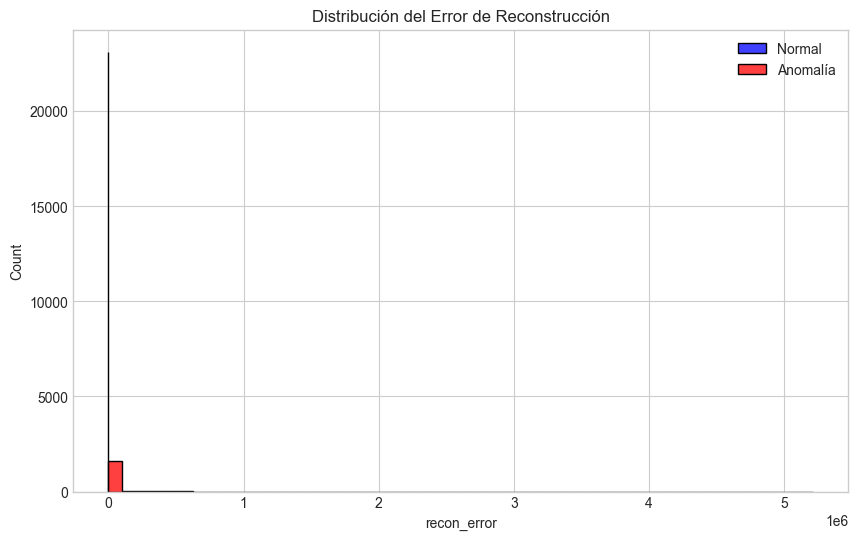

Umbral de anomalía definido en: 2.5281

--- Evaluación en el set de prueba ---
777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step

Resultados para el VAE (Detección de Anomalías):
              precision    recall  f1-score   support

      Normal       0.99      0.95      0.97     23136
    Anomalía       0.57      0.92      0.70      1723

    accuracy                           0.95     24859
   macro avg       0.78      0.93      0.84     24859
weighted avg       0.96      0.95      0.95     24859

ROC-AUC: 0.9898542966608308

Entrenando y evaluando XGBoost por sí solo...

Resultados para XGBoost (Clasificación Supervisada):
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99     23136
    Anomalía       0.90      0.95      0.93      1723

    accuracy                           0.99     24859
   macro avg       0.95      0.97      0.96     24859
weighted avg       0.99      0.99      0.99     24859

ROC-AUC: 0.9990140185987482

Evaluando el Mod

c:\Users\sesea4\Desktop\Anteproyecto\Proyecto\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:26:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


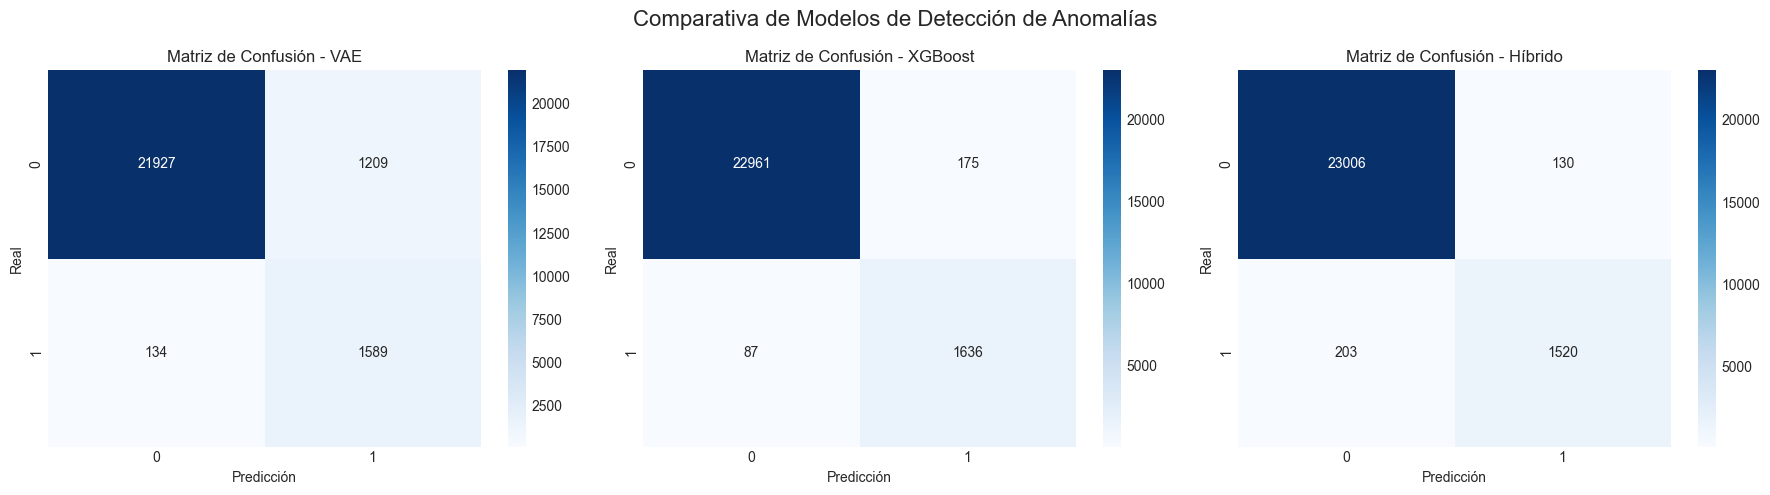

In [9]:
# =====================================================================
# PARTE 2: MODELO HÍBRIDO DE DETECCIÓN (VAE + CLASIFICADOR)
# =====================================================================

print("\nIniciando implementación del modelo híbrido (VAE + XGBoost)...")

# --- 1. Selección de Características y Preprocesamiento ---
features = [
    'ingreso_anual_neto_total',
    'sueldo_anual_publico',
    'otros_ingresos_anuales',
    'valor_total_activos',
    'valor_total_deuda',
    'conteo_inmuebles',
    'conteo_vehiculos',
    'conteo_inversiones'
]

# Creamos un dataframe limpio solo con las características y la etiqueta
df_model = df[features + ['posible_anomalia']].copy()

# Manejo de valores faltantes (si los hubiera)
df_model.fillna(0, inplace=True)

# Separar datos normales y anómalos
df_normal = df_model[df_model['posible_anomalia'] == 0]
df_anomaly = df_model[df_model['posible_anomalia'] == 1]

print(f"Datos separados: {len(df_normal)} declaraciones normales y {len(df_anomaly)} anómalas.")

# --- 2. División de Datos (Entrenamiento, Validación, Prueba) ---
# Usaremos solo datos normales para entrenar el VAE
X_normal = df_normal[features]
X_anomaly = df_anomaly[features]

# Dividimos los datos normales para tener en todos los sets
X_train_normal, X_test_normal = train_test_split(X_normal, test_size=0.3, random_state=42)
X_test_normal, X_val_normal = train_test_split(X_test_normal, test_size=0.5, random_state=42)

# Dividimos las anomalías para validación y prueba
X_val_anomaly, X_test_anomaly = train_test_split(X_anomaly, test_size=0.5, random_state=42)

# Creamos los sets de validación y prueba
X_val = pd.concat([X_val_normal, X_val_anomaly])
y_val = np.concatenate([np.zeros(len(X_val_normal)), np.ones(len(X_val_anomaly))])

X_test = pd.concat([X_test_normal, X_test_anomaly])
y_test = np.concatenate([np.zeros(len(X_test_normal)), np.ones(len(X_test_anomaly))])

# Estandarización de los datos (muy importante para redes neuronales)
scaler = StandardScaler()
X_train_normal_scaled = scaler.fit_transform(X_train_normal)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Set de entrenamiento (VAE, solo normales): {X_train_normal_scaled.shape}")
print(f"Set de validación (mixto): {X_val_scaled.shape}")
print(f"Set de prueba (mixto): {X_test_scaled.shape}")

# --- 3. Construcción y Entrenamiento del Autoencoder Variacional (VAE) ---

# Parámetros del modelo
input_dim = X_train_normal_scaled.shape[1]
latent_dim = 2 # Dimensión del espacio latente, como en el paper
intermediate_dim = 16

# --- Definición del Encoder ---
encoder_inputs = tf.keras.Input(shape=(input_dim,))
h = Dense(intermediate_dim, activation='relu')(encoder_inputs)
z_mean = Dense(latent_dim, name='z_mean')(h)
z_log_var = Dense(latent_dim, name='z_log_var')(h)

# Función de muestreo (Reparameterization Trick)
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()


# --- Definición del Decoder ---
latent_inputs = tf.keras.Input(shape=(latent_dim,))
decoder_h = Dense(intermediate_dim, activation='relu')(latent_inputs)
decoder_outputs = Dense(input_dim, activation='sigmoid')(decoder_h)
decoder = Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()


# --- Creación de la Clase VAE para manejar la lógica de entrenamiento ---
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        # La data de entrada es X, y la salida esperada (y) es también X
        x, y = data 
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(y, reconstruction), axis=-1
                )
            )
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    # Se necesita un método 'test_step' para que la validación funcione correctamente
    def test_step(self, data):
        x, y = data
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                tf.keras.losses.binary_crossentropy(y, reconstruction), axis=-1
            )
        )
            
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss
        
        # Actualiza las métricas con los valores de validación
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    # El método 'call' es para la predicción/inferencia
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)


# --- Instanciar y Entrenar el Modelo VAE ---
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

print("\nEntrenando el VAE (esto puede tardar unos minutos)...")
history = vae.fit(X_train_normal_scaled, X_train_normal_scaled,
                  epochs=50,
                  batch_size=32,
                  shuffle=True,
                  validation_data=(X_val_scaled, X_val_scaled),
                  verbose=1)

# --- 4. Cálculo del Umbral de Anomalía ---
print("\nCalculando el umbral de error de reconstrucción...")
reconstructions = vae.predict(X_val_scaled)
mse = np.mean(np.power(X_val_scaled - reconstructions, 2), axis=1)
error_df = pd.DataFrame({'recon_error': mse, 'true_class': y_val})

# Visualización del error de reconstrucción
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(error_df[error_df['true_class'] == 0]['recon_error'], bins=50, ax=ax, color='blue', label='Normal')
sns.histplot(error_df[error_df['true_class'] == 1]['recon_error'], bins=50, ax=ax, color='red', label='Anomalía')
ax.set_title("Distribución del Error de Reconstrucción")
ax.legend()
plt.show()

# Definimos el umbral (ej. percentil 95 del error de las clases normales)
threshold = np.percentile(error_df[error_df['true_class'] == 0]['recon_error'], 95)
print(f"Umbral de anomalía definido en: {threshold:.4f}")

# --- 5. Evaluación de los Tres Enfoques en el Set de Prueba ---
print("\n--- Evaluación en el set de prueba ---")

# a) Enfoque 1: Solo VAE
test_reconstructions = vae.predict(X_test_scaled)
test_mse = np.mean(np.power(X_test_scaled - test_reconstructions, 2), axis=1)
y_pred_vae = [1 if e > threshold else 0 for e in test_mse]

print("\nResultados para el VAE (Detección de Anomalías):")
print(classification_report(y_test, y_pred_vae, target_names=['Normal', 'Anomalía']))
print("ROC-AUC:", roc_auc_score(y_test, test_mse))


# b) Enfoque 2: Solo XGBoost
print("\nEntrenando y evaluando XGBoost por sí solo...")
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(len(y_val)-sum(y_val))/sum(y_val))

# Entrenamos XGBoost con los datos de validación (que están mezclados y etiquetados)
xgb.fit(X_val_scaled, y_val)
y_pred_xgb = xgb.predict(X_test_scaled)
y_pred_proba_xgb = xgb.predict_proba(X_test_scaled)[:, 1]

print("\nResultados para XGBoost (Clasificación Supervisada):")
print(classification_report(y_test, y_pred_xgb, target_names=['Normal', 'Anomalía']))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_xgb))


# c) Enfoque 3: Modelo Híbrido (VAE como filtro + XGBoost)
print("\nEvaluando el Modelo Híbrido (VAE + XGBoost)...")
# El VAE identifica las 'sospechosas'
indices_sospechosos = [i for i, e in enumerate(test_mse) if e > threshold]
X_test_sospechosos = X_test_scaled[indices_sospechosos]

# El clasificador XGBoost re-evalúa solo esas
y_pred_final_xgb = xgb.predict(X_test_sospechosos)

# Construimos el vector de predicción final del modelo híbrido
y_pred_hibrido = np.zeros_like(y_test)
for i, pred in zip(indices_sospechosos, y_pred_final_xgb):
    y_pred_hibrido[i] = pred

print("\nResultados para el Modelo Híbrido:")
print(classification_report(y_test, y_pred_hibrido, target_names=['Normal', 'Anomalía']))
print("ROC-AUC (aproximado):", roc_auc_score(y_test, y_pred_hibrido)) # La probabilidad no es directa, pero la clasificación binaria nos da una idea.

# --- Conclusión y Comparativa (Matrices de Confusión) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
models = {'VAE': y_pred_vae, 'XGBoost': y_pred_xgb, 'Híbrido': y_pred_hibrido}
for i, (model_name, y_pred) in enumerate(models.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Matriz de Confusión - {model_name}')
    axes[i].set_xlabel('Predicción')
    axes[i].set_ylabel('Real')
fig.suptitle('Comparativa de Modelos de Detección de Anomalías', fontsize=16)
plt.tight_layout()
plt.show()

`Pensamientos: No es mejor XGBoost? Realmente lo que interesa con esto es que detecte la mayor cantidad de anomalias reales posibles y se le pasen las menos, no importa si tiene mas falsos positivos. Aunque el tener un mayor numero de anomalias detectadas tanto verdaderas como falsas hace que a la hora de hacer la revision tengan que revisar mas y si batallan ahorita con 200, aunque le atine a mas tienen mucho que revisar. Otra clasificacion para anomalia puede ser "error de dedo" o algo por el estilo que sean anomalias exageradas como el director de secundaria de 500M. Asi despues los usuarios podrias revisar esas nomas con eso e irse mas rapido.`

## Parte 3: Autoencoder como Extractor de Características (FEATURE ENRICHMENT)

Extrayendo características latentes para los sets de validación y prueba...
777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step
777/777 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step
Forma de las características originales de validación: (24859, 8)
Forma de las nuevas características latentes: (24859, 2)
Forma del nuevo set de validación 'aumentado': (24859, 10)

Entrenando un nuevo XGBoost con las características aumentadas...

--- Resultados para XGBoost con Características Enriquecidas ---
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99     23136
    Anomalía       0.90      0.95      0.93      1723

    accuracy                           0.99     24859
   macro avg       0.95      0.97      0.96     24859
weighted avg       0.99      0.99      0.99     24859

ROC-AUC: 0.9990140185987482


c:\Users\sesea4\Desktop\Anteproyecto\Proyecto\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:27:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


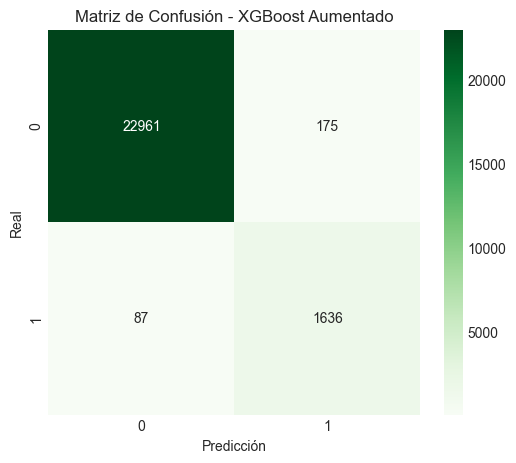

In [10]:
# --- 1. Extraer Características del Espacio Latente usando el Encoder ---
# Usamos el 'encoder' que ya fue entrenado como parte de nuestro VAE.
# El encoder devuelve: z_mean, z_log_var, z. Usaremos 'z_mean' como la representación estable.

print("Extrayendo características latentes para los sets de validación y prueba...")

# Extraer para el set de validación (que usaremos para entrenar el nuevo XGBoost)
val_z_mean, _, _ = vae.encoder.predict(X_val_scaled)

# Extraer para el set de prueba (que usaremos para evaluar)
test_z_mean, _, _ = vae.encoder.predict(X_test_scaled)

print(f"Forma de las características originales de validación: {X_val_scaled.shape}")
print(f"Forma de las nuevas características latentes: {val_z_mean.shape}")


# --- 2. Crear los Datasets "Aumentados" ---
# Combinamos las características originales (escaladas) con las nuevas del espacio latente.
X_val_augmented = np.concatenate([X_val_scaled, val_z_mean], axis=1)
X_test_augmented = np.concatenate([X_test_scaled, test_z_mean], axis=1)

print(f"Forma del nuevo set de validación 'aumentado': {X_val_augmented.shape}")


# --- 3. Entrenar y Evaluar XGBoost con Características Enriquecidas ---
print("\nEntrenando un nuevo XGBoost con las características aumentadas...")

# Creamos una nueva instancia del clasificador
# Usamos el mismo 'scale_pos_weight' para manejar el desbalance de clases
xgb_augmented = XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss', 
    scale_pos_weight=(len(y_val)-sum(y_val))/sum(y_val)
)

# Entrenamos el modelo con el set de validación aumentado
xgb_augmented.fit(X_val_augmented, y_val)

# Hacemos predicciones en el set de prueba aumentado
y_pred_xgb_augmented = xgb_augmented.predict(X_test_augmented)
y_pred_proba_xgb_augmented = xgb_augmented.predict_proba(X_test_augmented)[:, 1]

print("\n--- Resultados para XGBoost con Características Enriquecidas ---")
print(classification_report(y_test, y_pred_xgb_augmented, target_names=['Normal', 'Anomalía']))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba_xgb_augmented))

# --- Matriz de Confusión para el nuevo modelo ---
plt.figure(figsize=(6, 5))
cm_augmented = confusion_matrix(y_test, y_pred_xgb_augmented)
sns.heatmap(cm_augmented, annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusión - XGBoost Aumentado')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

`Sigue siendo mejor XGBoost, se le pasan menos (checar VAE como un detector de patrones nuevos)`

### GUARDAR MODELOS

In [12]:
import joblib
import json

# --- Directorio para guardar los modelos ---
import os
model_dir = 'modelos_desplegables'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

print(f"Guardando artefactos del modelo en la carpeta '{model_dir}'...")

# 1. Guardar el Encoder del VAE (usando el formato nativo de Keras)
vae.encoder.save(os.path.join(model_dir, 'encoder_model.keras'))
print("Encoder guardado.")

# 2. Guardar el modelo XGBoost (usaremos joblib)
# Usaremos el modelo 'aumentado' que creaste en el último enfoque
joblib.dump(xgb_augmented, os.path.join(model_dir, 'xgb_augmented_model.joblib'))
print("Modelo XGBoost guardado.")

# 3. Guardar el objeto Scaler (¡muy importante!)
joblib.dump(scaler, os.path.join(model_dir, 'scaler.joblib'))
print("Scaler guardado.")

# 4. Guardar el umbral y la lista de características en un archivo de configuración
config = {
    'threshold': threshold,
    'features': features
}
with open(os.path.join(model_dir, 'config.json'), 'w') as f:
    json.dump(config, f)
print("Archivo de configuración guardado.")

print("\n¡Listo! Todos los componentes han sido guardados.")

Guardando artefactos del modelo en la carpeta 'modelos_desplegables'...
Encoder guardado.
Modelo XGBoost guardado.
Scaler guardado.
Archivo de configuración guardado.

¡Listo! Todos los componentes han sido guardados.
